In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abstract_udmis import AbstractUDMIS
import networkx as nx
from collections import defaultdict

In [2]:
import torch
from torch import optim

In [3]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
        
    def find_edges(self):
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices - 1):
            x_i, y_i = graph[i]
            
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j]
                
                
                #calc distance
                dij = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
    
    def energy(self):
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices - 1):
            for j in range(i+1, self.num_vertices):
                
                
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                    
            vertex_term += self.occupations[i]
            
        #missed last vertex
        vertex_term += self.occupations[self.num_vertices - 1]
        
        return u*interaction_term - vertex_term
    
    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping occupied vertex
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
            
        elif self.occupations[i] == 0:
            #flipping unnocupied vertex
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied
            
        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        return np.random.randint(self.num_vertices)
    
    
    def draw_graph(self):
        G = nx.from_numpy_array(self.edges)
        graph_np = np.array(self.graph)
        xs = graph_np[:,0]
        ys = graph_np[:,1]
        cs = self.occupations

        fig, ax = plt.subplots()
        
        # plot the non activated vertices in the background
        for x,y,c in zip(xs,ys,cs):
            if not(c):
                circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
                ax.add_patch(circle)
                
        for x,y,c in zip(xs,ys,cs):
            if c:
                circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
                ax.add_patch(circle)
        
        nx.draw(G, pos=self.graph, node_color='r', edge_color='b',ax=ax)
        ax.axis('equal')
        
        return fig,ax

In [4]:
def draw_graph_state(graph,occupationlist, ax):
    G = nx.from_numpy_array(graph.edges)
    graph_np = np.array(graph.graph)
    xs = graph_np[:,0]
    ys = graph_np[:,1]
    cs = occupationlist

    # plot the non activated vertices in the background
    for x,y,c in zip(xs,ys,cs):
        if not(c):
            circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
            ax.add_patch(circle)

    for x,y,c in zip(xs,ys,cs):
        if c:
            circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
            ax.add_patch(circle)

    nx.draw(G, pos=graph.graph, node_color='r', edge_color='b',ax=ax)
    ax.axis('equal')

In [5]:
u = 1.35

In [8]:
[i for i in range(5,525,20)]

[5,
 25,
 45,
 65,
 85,
 105,
 125,
 145,
 165,
 185,
 205,
 225,
 245,
 265,
 285,
 305,
 325,
 345,
 365,
 385,
 405,
 425,
 445,
 465,
 485,
 505]

In [10]:
graphs = []
for i in range(5,525,20):
    density = 1
    scale = np.sqrt(i)/density
    graphs.append([(np.random.rand()*scale,np.random.rand()*scale) for n in range(i)])

In [11]:
N = 100
t = np.arange(N+1)
T_i = 100
T_f = 0.01

In [12]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
lmbda = lambda epoch: 0.65 ** epoch

In [13]:
benchmarks = defaultdict()
for i,graph in enumerate(graphs):
    test = UDMIS(u,graph)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
    annealing = np.zeros((N,3))
    for k,t in enumerate(range(N)):
        optimizer.step()    
        temp = optimizer.param_groups[0]["lr"] + 0.0001
        E, dE = test.mc_step(T=temp)
        annealing[k,0] = temp
        annealing[k,1] = E
        annealing[k,2] = dE
        scheduler.step()
        
    benchmarks[i] = annealing

5
25
45
65
85
105
125
145
165
185
205
225
245
265
285
305
325
345
365
385
405
425
445
465
485
505


In [14]:
benchmarks_exp = defaultdict()
for i,graph in enumerate(graphs):
    test = UDMIS(u,graph)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
    annealing = np.zeros((N,3))
    for k,t in enumerate(range(N)):
        optimizer.step()    
        temp = optimizer.param_groups[0]["lr"]
        E, dE = test.mc_step(T=temp)
        annealing[k,0] = temp
        annealing[k,1] = E
        annealing[k,2] = dE
        scheduler.step()
        
    benchmarks_exp[i] = annealing

5
25
45
65
85
105
125
145
165
185
205
225
245
265
285
305
325
345
365
385
405
425
445
465
485
505


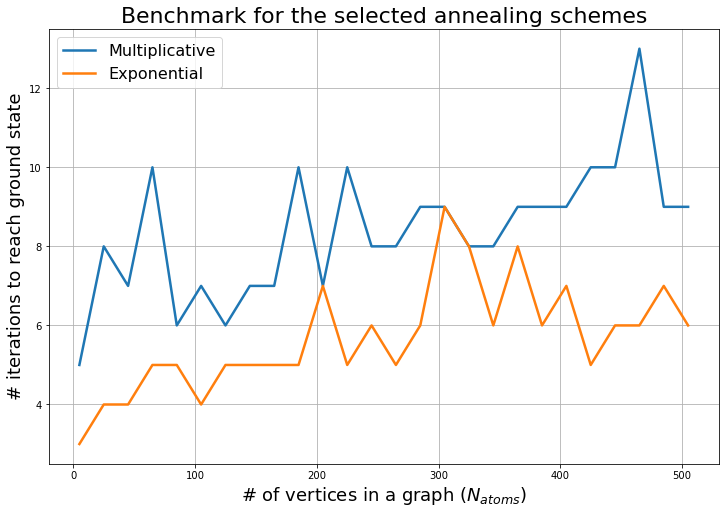

In [18]:
plt.figure(figsize=(12,8))
plt.plot(range(5,525,20),[np.argmin(benchmarks[k][:,1]) for k in benchmarks.keys()],lw=2.5, label='Multiplicative')
plt.plot(range(5,525,20),[np.argmin(benchmarks_exp[k][:,1]) for k in benchmarks_exp.keys()],lw=2.5, label='Exponential')
plt.title('Benchmark for the selected annealing schemes', fontsize=22)
plt.ylabel('# iterations to reach ground state', fontsize=18)
plt.xlabel('# of vertices in a graph ($N_{atoms}$)', fontsize=18)
plt.grid()
plt.legend(fontsize=16)
plt.savefig('figs task 1/Benchmarks_Multi_exp_annealing.png', dpi=250, bbox_inches='tight')